In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import sys
import os
from datetime import datetime

from sklearn.metrics import classification_report
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)


2022-09-07 02:39:11.802062: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
import random
import math
from numpy import genfromtxt
import resampy
import matplotlib.pyplot as plt

In [5]:
!pip install seaborn


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data_root = Path("/data/stg60/milton_plotdata")
#data_milton_par = Path("/data/stg60/milton_plotdata/Milton_for_parameter_est/")
data_milton_par = Path("/data/stg60/milton_plotdata/test/")
data_milton_pred=Path("/data/stg60/milton_plotdata/Milton_for_prediction/")

In [8]:
def strides(a, L = 128, S=1):  # Window len = L, Stride len/stepsize = S
    tolist = False
    if isinstance(a, list):
        tolist = True
        a = np.array(a)
    if S is None:
        S = math.ceil(a.size/10)
    nrows = ((a.size - L) // S) + 1
    n = a.strides[0]
    #print(n)
    windows = np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S * n, n))
    
    if tolist:
        windows = windows.tolist()
    return windows
def read_tsv(tsv, start_index = 1024, end_index = None, scale = True):
    dat = genfromtxt(tsv, delimiter='\t')
    x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
    ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
    ang_sin_x_1=(x1-x4)/ell_1
    phi =np.arcsin(ang_sin_x_1)*180/np.pi
    phi = phi.reshape(-1)[start_index:end_index]
    x1 = x1.reshape(-1)[start_index:end_index]
    phi = resampy.resample(phi, sr_orig = 250, sr_new = 100)
    x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
    if scale:
        phi = phi/20
        x1 = x1/0.335
    return phi, x1
def prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None, scale = True):
    """AI is creating summary for prepareData

    Args:
        path ([Str]): [path to the original file]
        cutoff (int, optional): [description]. Defaults to 128.
        delay (int, optional): [description]. Defaults to 23.
        L (int, optional): [Window size]. Defaults to 128.
        timetopredict (float, optional): [description]. Defaults to 1.96.
        samplingrate (int, optional): [description]. Defaults to 100.
        fall_stride (int, optional): [description]. Defaults to 1.
        start_index (int, optional): [description]. Defaults to 1024.
        end_index ([type], optional): [description]. Defaults to None.
        scale (bool, optional): [description]. Defaults to True.
    Returns:
        [type]: [description]

    Yields:
        [type]: [description]
    """
    # timetopredict in seconds, note 1 point = 0.01 seconds, or 100points = 1seconds
    def disect(*args, separator = None):
        for arg in args:
            nofall, fall = arg[:-separator], arg[-separator:]
            yield (nofall, fall)
    
    if path.suffix == ".mat":    
        if not isinstance(path, str):
            path = path.as_posix()
        mat = loadmat(path)
        phiv = mat['phiv'].reshape(-1)
        dxv = mat['dxv'].reshape(-1)
        if scale:
            phiv = phiv/20
            dxv = dxv/0.335
    elif path.suffix == ".tsv":
        phiv, dxv = read_tsv(path, start_index = start_index, end_index=end_index)

    phiv = phiv[:-cutoff]
    dxv = dxv[:-cutoff]

    #phiv -> delay, respo
    delay_phiv = phiv[delay:]
    respo_phiv = phiv[:-delay]

    #dxv -> delay, respo
    delay_dxv = dxv[delay:]
    respo_dxv = dxv[:-delay]

    #fall region
    fall_region = L + int(timetopredict*samplingrate)
    [(n_delay_phiv, f_delay_phiv), (n_respo_phiv, f_respo_phiv)] = disect(delay_phiv, respo_phiv, separator=fall_region)
    [(n_delay_dxv, f_delay_dxv), (n_respo_dxv, f_respo_dxv)] = disect(delay_dxv, respo_dxv, separator=fall_region)

    if n_delay_phiv.size < f_delay_phiv.size:
        S = 1
    else:
        S = math.ceil((n_delay_phiv.size - f_delay_phiv.size)/(timetopredict*samplingrate+1))

    #s=1 for imbalanced
    # no_fall_windows
    n_delay_phiv = strides(n_delay_phiv, L = L, S = S)
    n_respo_phiv = strides(n_respo_phiv, L = L, S = S)
    n_delay_dxv = strides(n_delay_dxv, L = L, S = S)
    n_respo_dxv = strides(n_respo_dxv, L = L, S = S)

    # fall_windows
    f_delay_phiv = strides(f_delay_phiv, L = L, S = fall_stride)
    #f_delay_phiv1 = strides(f_delay_phiv, L = L, S = fall_stride)
    f_respo_phiv = strides(f_respo_phiv, L = L, S = fall_stride)
    f_delay_dxv = strides(f_delay_dxv, L = L, S = fall_stride)
    f_respo_dxv = strides(f_respo_dxv, L = L, S = fall_stride)

    # concatenate features
    n_x = np.stack((n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv), -1)
    f_x = np.stack((f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv), -1)

    n_y = np.zeros(n_x.shape[0]).reshape(-1,1)
    f_y = np.ones(f_x.shape[0]).reshape(-1,1)

    x = np.concatenate((n_x,f_x), 0)
    y = np.concatenate((n_y,f_y), 0)

    return x, y, S, f_delay_phiv,f_delay_phiv

In [9]:
def getOneHugeArray(path_list, start_index_list = None, end_index_list = None):
    datax = []
    datay = []
    if start_index_list is None and end_index_list is None:    
        for path in tqdm(path_list):
            x,y,_,a,b = prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1)
            datax.append(x)
            datay.append(y)
    else:
        for path, start_index, end_index in tqdm(zip(path_list, start_index_list, end_index_list)):
            x,y,_,a,b = prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = start_index, end_index = end_index)
            datax.append(x)
            datay.append(y)
    x = np.concatenate(datax)    
    y = np.concatenate(datay)

    return x, y,a,b
def create_Real_Data(data_path_list, mode = "pred"):
    phi_data=[]
    data_path_list = sorted(data_path_list.glob('*.tsv'))
    start_index_list = [1024]*len(data_path_list)
    end_index_list = [None]*len(data_path_list)
    for x in tqdm(data_path_list):
        phi,_ = read_tsv(x)
        phi_data.append(phi)
        plt.plot(phi, label = x.name)
    plt.legend()
    plt.savefig(f"plots_{mode}.png")

    x, y,a,b = getOneHugeArray(data_path_list, start_index_list = start_index_list, end_index_list = end_index_list)
    # print(x)
    # print("break")
    # print(y)
    # # print(x[204])
    # print("break")
    # print(y[207])
    
    
    print(x.shape, y.shape, y.sum()/y.size)
    np.savez(data_root/f"{mode}.npz", x = x, y = y)
    return x,y,start_index_list,end_index_list,phi_data,a,b

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
1it [00:00, 14.32it/s]

(404, 128, 4) (404, 1) 0.4876237623762376


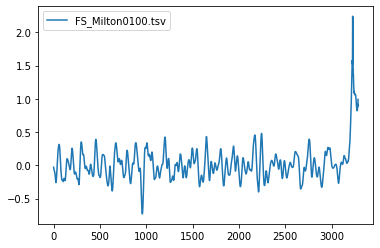

In [10]:
x,y,start_index_list,end_index_list,phi,a,b= create_Real_Data(data_milton_par, mode = "pred_test")



In [13]:
len(a)

197

In [14]:
np.max(abs(a))

0.3297891486470766

In [55]:
np.max(abs(b))

0.3297891486470766

In [15]:
len(x)

404

In [38]:
len(phi[0])

3286

In [103]:
np.max(abs(x))

574.9806103586961

In [11]:
m=np.max(abs(y))
print(m)

1.0


In [12]:
#print(x[207])
np.max(abs(x[201]))

341.7354879030425

In [11]:
test1='/data/stg60/milton_plotdata/test/FS_Milton0100.tsv'

In [12]:
dat = genfromtxt(test1, delimiter='\t')
x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
ang_sin_x_1=(x1-x4)/ell_1
phi1=np.arcsin(ang_sin_x_1)*180/np.pi


In [13]:
x1 = x1.reshape(-1)[1024:None]
x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
 
  
        

In [17]:
x1

array([ 24.06375677,  38.52008343,  34.46336092, ..., 303.40358861,
       287.4602172 , 309.4479162 ])

In [18]:
x1 = x1/0.335  

In [19]:
x1

array([ 71.83210975, 114.98532367, 102.87570425, ..., 905.68235406,
       858.09020059, 923.72512299])

In [11]:
x1

array([[-32.349],
       [-32.415],
       [-32.483],
       ...,
       [291.419],
       [289.721],
       [288.087]])

In [45]:
type(phi1)

numpy.ndarray

In [59]:
len(phi1)

9239

In [14]:
phi1 = phi1.reshape(-1)[1024:None]
#phi1 = phi1.reshape(-1)
phi1 = resampy.resample(phi1, sr_orig = 250, sr_new = 100)
phi1 = phi1/20

In [15]:
len(phi1)

3286

In [88]:
phiv = phi1[:-128]

In [90]:
len(phiv)

3158

In [97]:
delay_phiv = phiv[23:]
respo_phiv = phiv[:-23]

In [98]:
len(delay_phiv)

3135

In [99]:
len(respo_phiv)

3135

In [48]:
np.max(abs(phi1))

2.2407087739368676

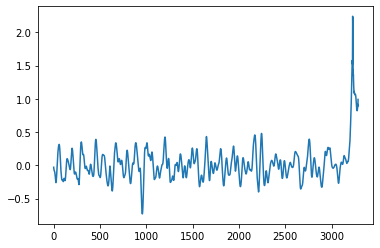

In [16]:
plt.plot(phi1)

100%|██████████| 9/9 [00:00<00:00, 17.75it/s]
9it [00:00, 18.27it/s]


(3637, 128, 4) (3637, 1) 0.48748968930437175


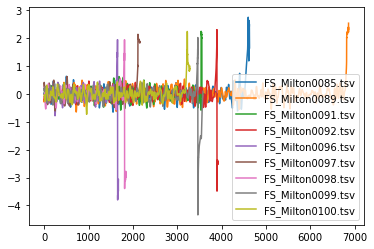

In [10]:

create_Real_Data(data_milton_pred, mode = "pred5")

In [17]:

trainpath = Path(f"/data/stg60/milton_plotdata/par.npz")
valpath = Path(f"/data/stg60/milton_plotdata/val.npz")
testpath = Path(f"/data/stg60/milton_plotdata/pred_test.npz")

In [18]:
checkpoint_root = f"/data/stg60/model_train_miltonsim/version_3"

checkpoint_path = f"{checkpoint_root}/model.ckpt"

In [19]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 28
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 128
limit=None
print('Train Loading')
with np.load(trainpath, allow_pickle=True) as data:
    train_examples = data['x'][:limit]
    train_labels = (data['y'][:limit]).astype(np.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(8)
print('Train Loaded')

print('Val Loading')
with np.load(valpath, allow_pickle=True) as data:
    val_examples = data['x']
    val_labels = (data['y']).astype(np.int64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels)).prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE)
print('Val Loaded')


print('Test Loading')
with np.load(testpath, allow_pickle=True) as data:
    test_examples = data['x']
    test_labels = (data['y']).astype(np.int64)

test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).prefetch(8)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)
print('Test Loaded')

Train Loading
Train Loaded
Val Loading
Val Loaded
Test Loading
Test Loaded


2022-09-07 02:40:04.141091: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-07 02:40:04.143328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-07 02:40:04.506220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-07 02:40:04.507161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-07 02:40:04.508036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:60:0

In [20]:
np.max(abs(test_examples))

574.9806103586961

In [21]:
test_examples[2][0][0]

0.24172916148439993

In [22]:
np.max(abs(test_examples[2][0][0]))

0.24172916148439993

In [21]:
len(test_examples)

404

In [23]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_data = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

In [24]:
print("Creating a model")
tf.keras.backend.set_floatx('float64')

Creating a model


In [25]:
strategy = tf.distribute.MirroredStrategy

In [26]:


    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 4)),
        tf.keras.layers.LayerNormalization(
            axis=1, epsilon=1e-10, center=True, scale=True,
            beta_initializer='zeros', gamma_initializer='ones',
        ),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),
        
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(1)
    ])
    model.load_weights(checkpoint_path)

    regularizer = tf.keras.regularizers.l1(0.01)
    for layer in model.layers:
     for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

    model.compile(optimizer=tf.keras.optimizers.SGD(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy'])
    





   

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [28]:
model.load_weights(checkpoint_path)

In [29]:
    print("Model Evaluation Started")
    
    y_prob = tf.sigmoid(model.predict(test_examples))
    #y_out = (y_prob > 0.84).numpy().astype("int32")
    y_out = (y_prob > 0.5).numpy().astype("int32")
    target_names = ['No-Fall', 'Fall']
    report = classification_report(test_labels, y_out, target_names=target_names, zero_division = 0)
    
    # with open(f"{rep_root}/test_report_version_{version_catalog}.txt","w") as f:
    #     f.write(report)
    print(report)

Model Evaluation Started


2022-09-07 02:40:48.367236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-07 02:40:48.386084: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-09-07 02:40:49.765155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-07 02:40:50.533930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


              precision    recall  f1-score   support

     No-Fall       0.61      0.55      0.58       207
        Fall       0.57      0.63      0.60       197

    accuracy                           0.59       404
   macro avg       0.59      0.59      0.59       404
weighted avg       0.59      0.59      0.59       404



In [42]:
len(test_examples)

404

In [40]:
len(test_labels)

404

In [30]:
not_matched=[]
matched=[]
for i in range(0,len(test_labels)):
    if test_labels[i]!= y_out[i]:
        not_matched.append(i)
    else:
        matched.append(i)



     

In [ ]:
len(not_matched)
not_matched

In [31]:
len(matched)

238

In [32]:
feature_1=[]
for i in range(0,127):
    feature_1.append(test_examples[2][i][0])
    

In [33]:
len(not_matched)

166

In [34]:
feature1=[]
for j in range (0,166):
    col=[]
    for i in range(0,127):
        col.append(test_examples[not_matched[j]][i][0])

    feature1.append(col)

In [35]:
feature1_total=[]
for j in range (0,404):
    col=[]
    for i in range(0,127):
        col.append(test_examples[j][i][0])

    feature1_total.append(col)

In [36]:
feature1_total=np.array(feature1_total)

In [37]:
feature1_total_flatten=feature1_total.flatten()

In [38]:
feature1_total_flatten.shape

(51308,)

In [71]:
not_matched

[2,
 6,
 7,
 8,
 11,
 13,
 14,
 15,
 29,
 37,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 62,
 64,
 65,
 68,
 69,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 80,
 81,
 87,
 88,
 89,
 90,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 111,
 112,
 114,
 119,
 122,
 123,
 126,
 131,
 132,
 135,
 137,
 139,
 140,
 141,
 145,
 146,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 160,
 161,
 162,
 165,
 166,
 167,
 170,
 171,
 175,
 176,
 180,
 187,
 188,
 190,
 195,
 196,
 197,
 198,
 202,
 203,
 204,
 205,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 289,
 290,
 291,
 292,
 317,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403]

In [39]:
feature1_total.shape

(404, 127)

In [41]:
feature1=np.array(feature1)

In [42]:
feature1.shape

(166, 127)

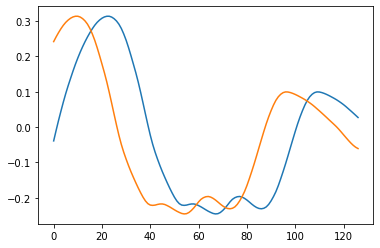

In [43]:
plt.plot(feature1_total[1])
plt.plot(feature1_total[2])

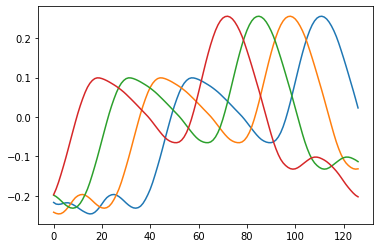

In [48]:
plt.plot(feature1_total[5])
plt.plot(feature1_total[6])
plt.plot(feature1_total[7])
plt.plot(feature1_total[8])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten[0:1000])
high=[]
low=[]

# for j in range (0,1000):
#     for i in range (0,165):
#      l=(not_matched[i]-1)*128
#      low.append(l)
#      sum=128+l
#      high.append(sum)

ax.axvspan(129,128*2, color="blue", alpha=0.3)


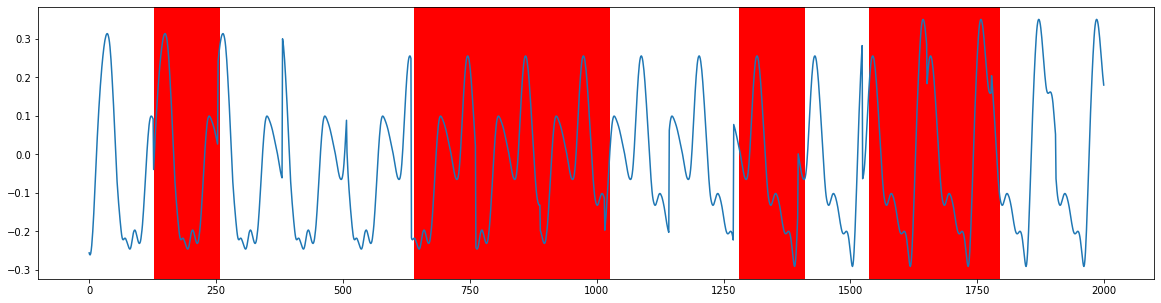

In [60]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten[0:2000])
high=[]
low=[]

for j in range (0,2000):
    for i in range (0,7):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

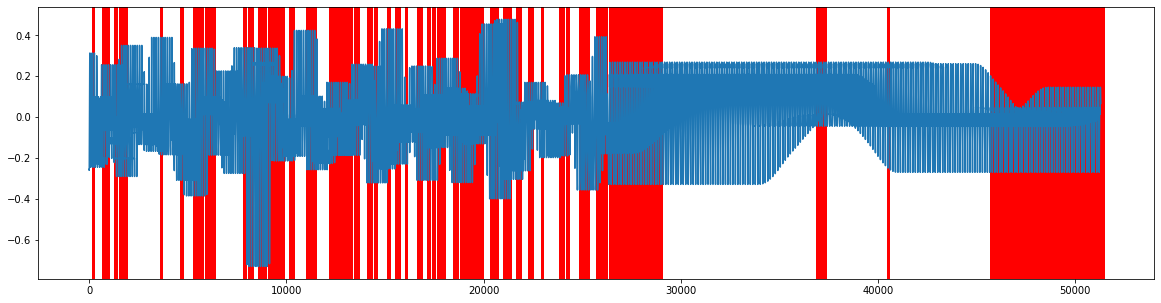

In [70]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,51307):
    for i in range (0,165):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

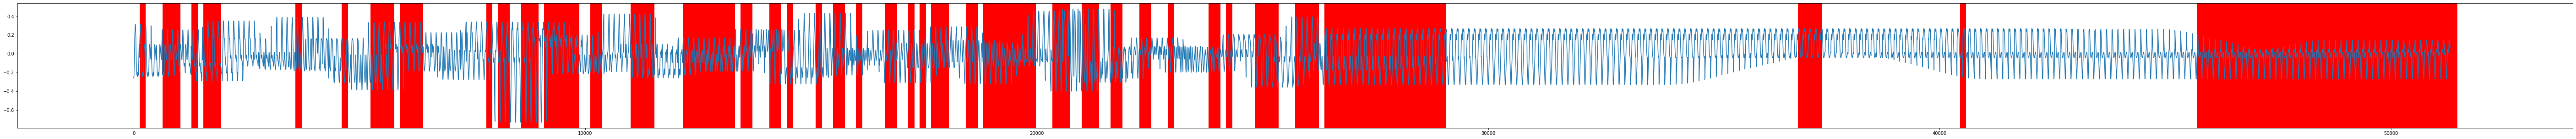

In [71]:
fig, ax = plt.subplots(figsize=(100, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,51307):
    for i in range (0,165):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

In [58]:
feature_1=[]
for j in range (0,166):
    for i in range(0,127):
     feature_1.append(test_examples[not_matched[j]][i][0])

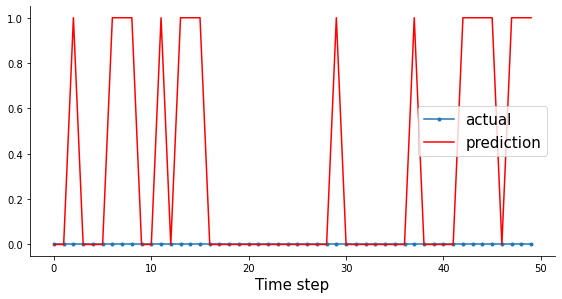

In [82]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[:50], marker='.', label="actual")
plt.plot(y_out[:50], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

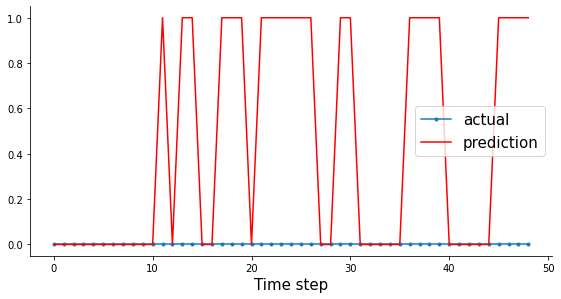

In [83]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[51:100], marker='.', label="actual")
plt.plot(y_out[51:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

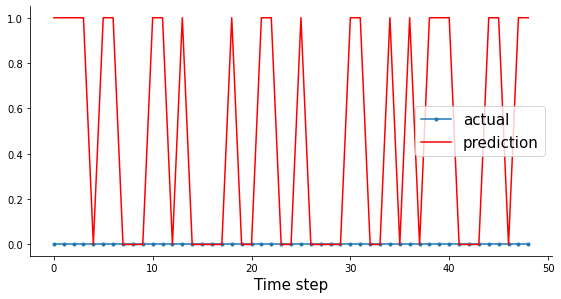

In [84]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[101:150], marker='.', label="actual")
plt.plot(y_out[101:150], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

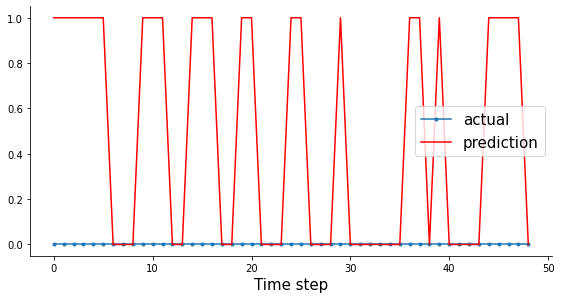

In [85]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[151:200], marker='.', label="actual")
plt.plot(y_out[151:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

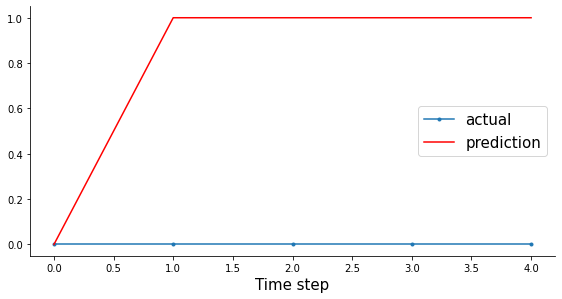

In [86]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[201:206], marker='.', label="actual")
plt.plot(y_out[201:206], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

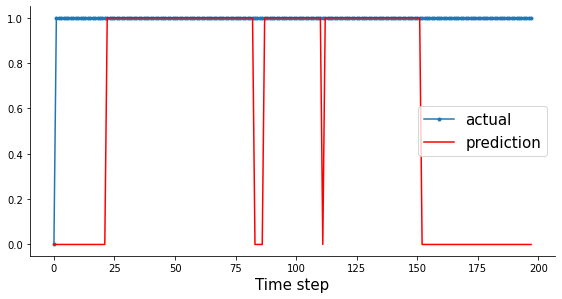

In [77]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[206:], marker='.', label="actual")
plt.plot(y_out[206:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

In [33]:
# y_out

In [35]:
dat = genfromtxt("/data/stg60/milton_plotdata/Milton_for_prediction/FS_Milton0096.tsv", delimiter='\t')
x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
ang_sin_x_1=(x1-x4)/ell_1
phi1=np.arcsin(ang_sin_x_1)*180/np.pi

In [136]:
len(test_labels)

404

In [137]:
len(y_out)

404

numpy.ndarray

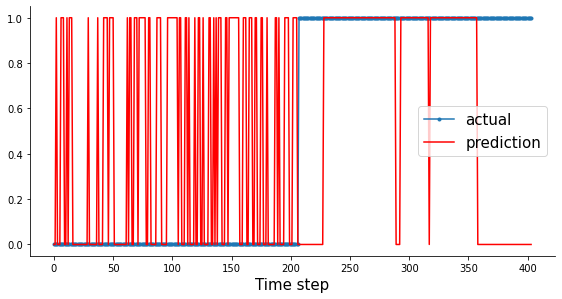

In [93]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels, marker='.', label="actual")
plt.plot(y_out, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();